## Residue mapping for globular protein

- Original idea from https://zenodo.org/records/4090925

In [33]:
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import biotite.structure as struc
import biotite.database.rcsb as rcsb
import biotite.structure.io.pdbx as pdbx


# Config
RADIUS = 1.8
MARGIN = 5.0

# If you want a slightly nicer 2D view, we can scan "roll" angles around the
# first principal axis to reduce overlaps (still CA-only).
USE_BEST_ROLL = True 
ROLL_STEPS = 240 # e.g. 240 steps = 1.5 degree resolution

# Optional gentle repel to reduce overlaps (CA-only)
USE_RELAX = True
RELAX_MIN_DIST = 0.06
RELAX_ITERS = 600

SCALE = 60.0  # just for nicer spacing

# Depth → transparency mapping (tune these)
ALPHA_FAR_CIRCLE = 0.1
ALPHA_NEAR_CIRCLE = 1.00
ALPHA_FAR_TEXT = 0.1
ALPHA_NEAR_TEXT = 1.00

# ---- Surface masking (CA-based heuristic) ----
MASK_BURIED = True           # turn on/off
NEIGHBOR_RADIUS_A = 10.0     # Å radius to count CA neighbors
BURIED_NEIGHBOR_CUTOFF = 22  # >= this many neighbors => buried (mask it)

# Mask behavior (grery and no text)
MASK_ALPHA_CIRCLE = 0.12
MASK_COLOR = "white"

# ----- Mask styling -----
USER_MASK_COLOR = "gray"
USER_MASK_ALPHA = 0.20

BURIED_MASK_COLOR = "lightsteelblue"
BURIED_MASK_ALPHA = 0.35


# Residue -> letter, class -> color
one_letter_code = {
    'ARG': 'R', 'HIS': 'H', 'LYS': 'K', 'ASP': 'D', 'GLU': 'E',
    'SER': 'S', 'THR': 'T', 'ASN': 'N', 'GLN': 'Q', 'CYS': 'C',
    'GLY': 'G', 'PRO': 'P', 'ALA': 'A', 'VAL': 'V', 'ILE': 'I',
    'LEU': 'L', 'MET': 'M', 'PHE': 'F', 'TYR': 'Y', 'TRP': 'W'
}

residue_class = {
    'ARG': 'b', 'HIS': 'b', 'LYS': 'b', 'ASP': 'a', 'GLU': 'a',
    'SER': 'w', 'THR': 'w', 'ASN': 'w', 'GLN': 'w', 'CYS': 's',
    'GLY': 'g', 'PRO': 'p', 'ALA': 'n', 'VAL': 'n', 'ILE': 'n',
    'LEU': 'n', 'MET': 's', 'PHE': 'n', 'TYR': 'n', 'TRP': 'n'
}

CLASS_TO_FILL = {
    "a": "red", "b": "skyblue", "w": "green", "g": "pink",
    "n": "white", "s": "yellow", "p": "purple",
}

def aa1(res3):
    return one_letter_code.get(res3.upper(), "X")

def aa_class(res3):
    return residue_class.get(res3.upper(), "n")


In [34]:
# Load CA only


def load_chain_atoms(file, chain_id, model: int = 1):
    # support file path or PDB ID; auto-detect format by extension or length
    if file.endswith(".cif"):
        arr = pdbx.CIFFile.read(file)
        arr = pdbx.get_structure(arr, model=model)
    elif file.endswith(".pdb"):
        arr = pdbx.PDBFile.read(file)
        arr = pdbx.get_structure(arr, model=model)
    elif len(file) == 4 and file.isalnum():
        pdb_id = file
        pdb_id = pdb_id.upper()
        cif_path = rcsb.fetch(pdb_id, "cif")
        cif = pdbx.CIFFile.read(cif_path)
        arr = pdbx.get_structure(cif, model=model)
    else:
        raise ValueError(f"Unsupported file format: {file}")
    
    aa = arr[struc.filter_amino_acids(arr) & (arr.chain_id == chain_id)]
    return aa

def extract_ca(chain_atoms):
    # Filter CA atoms and sort by residue id (ignoring insertion codes for simplicity)
    ca = chain_atoms[chain_atoms.atom_name == "CA"]
    order = np.argsort(ca.res_id.astype(int))
    ca = ca[order]
    print(f"Loaded {len(ca)} CA atoms")
    print(f"Residue IDs: {ca.res_id[0]} to {ca.res_id[-1]}")
    print(f"Residue names: {ca.res_name[0]} to {ca.res_name[-1]}")
    print(f"Coordinates range: {ca.coord.min(axis=0)} to {ca.coord.max(axis=0)}")
    print(f"Example CA atom: res_id={ca.res_id[0]}, res_name={ca.res_name[0]}, coord={ca.coord[0]}")
    print(f"Data types: res_id={ca.res_id.dtype}, res_name={ca.res_name.dtype}, coord={ca.coord.dtype}")
    
    return ca.res_id.astype(int), ca.res_name.astype(str), ca.coord.astype(float)



In [35]:
# Projection camera from reference
def pca_axes(X):
    # center and SVD for PCA axes
    Xc = X - X.mean(axis=0, keepdims=True)
    _, _, Vt = np.linalg.svd(Xc, full_matrices=False)
    print("PCA axes (rows):")
    print(Vt)
    return Vt[0], Vt[1], Vt[2]

def rotate_about_axis(v, axis, theta):
    # Rodrigues' rotation formula
    axis = axis / (np.linalg.norm(axis) + 1e-12)
    v_par = np.dot(v, axis) * axis
    v_perp = v - v_par
    result = v_par + v_perp*np.cos(theta) + np.cross(axis, v_perp)*np.sin(theta)
    print(f"Rotating vector {v} about axis {axis} by {theta:.2f} radians gives {result}")
    return result

def best_roll_theta(coords3d, n_steps=180, bead_radius=1.2, seed=0):
    # We want to find the roll angle around the first PCA axis that minimizes overlaps in the 2D projection.
    rng = np.random.default_rng(seed)
    # Center the coordinates
    X = coords3d - coords3d.mean(axis=0, keepdims=True)

    # Get PCA axes; we'll rotate the second axis around the first
    a, b0, _ = pca_axes(X)
    a = a / (np.linalg.norm(a) + 1e-12)
    b0 = b0 / (np.linalg.norm(b0) + 1e-12)
    print(f"Initial PCA axes: a={a}, b0={b0}")
    print(f"Testing {n_steps} roll angles around the first PCA axis to minimize overlaps...")

    def score_xy(xy):
        # Sample random pairs of points to estimate overlap and spread
        n = len(xy)
        if n < 2:
            return 0.0
        m = min(8000, n*(n-1)//2)
        i = rng.integers(0, n, size=m)
        j = rng.integers(0, n, size=m)
        mask = i != j
        d = xy[i[mask]] - xy[j[mask]]
        dist = np.sqrt((d*d).sum(axis=1))
        overlap = np.mean(dist < (2.2 * bead_radius))
        spread = float(np.quantile(dist, 0.10))
        print(f"Score for current angle: overlap={overlap:.4f}, spread={spread:.4f}")
        return -5.0*overlap + 1.0*spread

    best = (-np.inf, 0.0)
    for k in range(n_steps):
        theta = 2*np.pi*(k/n_steps)
        b = rotate_about_axis(b0, a, theta)
        b = b - np.dot(b, a) * a
        b = b / (np.linalg.norm(b) + 1e-12)
        x = X @ a
        y = X @ b
        xy = np.stack([x, y], axis=1)
        sc = score_xy(xy)
        if sc > best[0]:
            best = (sc, theta)
    print(f"Best roll angle: {best[1]:.2f} radians with score {best[0]:.4f}")

    return a, b0, best[1], best[0]

def project_with_camera_raw(coords3d, a, b0, theta):
    # Center the coordinates
    # Note: we should have already centered before PCA, 
    # so this is just to be safe. 
    # The projection will be the same as long as we are consistent.
    X = coords3d - coords3d.mean(axis=0, keepdims=True)

    b = rotate_about_axis(b0, a, theta)
    b = b - np.dot(b, a) * a
    b = b / (np.linalg.norm(b) + 1e-12)

    x = X @ a
    y = X @ b
    xy = np.stack([x, y], axis=1)

    return xy 


In [36]:
def ca_surface_mask(coords_ca: np.ndarray,
                    radius_a: float = 10.0,
                    buried_cutoff: int = 22) -> np.ndarray:
    """
    Return boolean mask (N,) where True = surface-like, False = buried,
    using CA neighbor count within radius.

    Heuristic:
      neighbors_i = number of other CA within radius_a
      surface if neighbors_i < buried_cutoff
    """
    X = coords_ca.astype(float)
    r2 = float(radius_a) ** 2

    # O(N^2) is fine for a few hundred residues; for huge proteins use a cell list.
    d2 = np.sum((X[:, None, :] - X[None, :, :]) ** 2, axis=2)
    within = (d2 < r2) & (d2 > 0.0)   # exclude self
    nnb = within.sum(axis=1)

    is_surface = nnb < buried_cutoff
    return is_surface


In [37]:
# Mask + draw
def build_mask(res_ids, mask_ranges):
    # res_ids: (N,) int array of residue IDs
    # mask_ranges: list of (start, end) tuples; inclusive ranges to mask
    if not mask_ranges:
        return np.zeros(len(res_ids), dtype=bool)
    mask = np.zeros(len(res_ids), dtype=bool)
    for start, end in mask_ranges:
        mask |= (res_ids >= start) & (res_ids <= end)
    return mask

def depth_to_alpha(depth, a_far, a_near):
    """
    depth: (N,) real values; larger = nearer (by our convention).
    Returns alpha in [a_far, a_near], with far=low alpha, near=high alpha.
    """
    dmin = float(np.min(depth)) # user defined convention: smaller depth = farther, larger depth = nearer
    dmax = float(np.max(depth))
    t = (depth - dmin) / (dmax - dmin + 1e-12)  # 0..1
    return a_far + (a_near - a_far) * t

# Depth-aware renderer (circles + text with different alpha)
def draw_on_axis_depth(ax,
                       xy,
                       depth,
                       res_names,
                       mask_type,
                       title,
                       *,
                       radius=RADIUS):

    ax.set_aspect("equal")
    ax.set_title(title, fontsize=16)

    # Alpha for circle + text from depth (masked residues override)
    a_circle = depth_to_alpha(depth, ALPHA_FAR_CIRCLE, ALPHA_NEAR_CIRCLE)
    a_text   = depth_to_alpha(depth, ALPHA_FAR_TEXT,   ALPHA_NEAR_TEXT)

    # Painter's algorithm: draw far -> near
    # Far = smaller depth => draw first; near = larger depth => draw last.
    order = np.argsort(depth)  # ascending

    for k, idx in enumerate(order):
        x, y = float(xy[idx, 0]), float(xy[idx, 1])
        rn = res_names[idx]
        mtype = mask_type[idx]

        if mtype == 1:
            face = USER_MASK_COLOR
            alpha_c = USER_MASK_ALPHA
        elif mtype == 2:
            face = BURIED_MASK_COLOR
            alpha_c = BURIED_MASK_ALPHA
        else:
            face = CLASS_TO_FILL.get(aa_class(rn), "white")
            alpha_c = float(a_circle[idx])


        # zorder rises with k so later (near) draws on top
        z_circle = 2 * k
        z_text = z_circle + 1

        ax.add_patch(
            Circle(
                (x, y),
                radius=radius,
                facecolor=face,
                edgecolor="black",
                linewidth=0.8,
                alpha=alpha_c,
                zorder=z_circle,
            )
        )

        # No text on masked residues
        if mtype == 0:
            ax.text(
                x, y,
                aa1(rn),
                ha="center", va="center",
                fontsize=RADIUS*5,
                fontweight="bold",
                alpha=float(a_text[idx]),
                zorder=z_text,
            )

    # N / C always visible
    xN, yN = xy[0]
    xC, yC = xy[-1]
    top = 2 * len(xy) + 8
    
    # Arrow offset (controls direction and distance)
    arrow_offset = -4 * radius   # negative = below, positive = above

    # N-terminal: blue arrow with black border
    ax.annotate(
        "",
        xy=(xN, yN),
        xytext=(xN, yN + arrow_offset),
        arrowprops=dict(
            arrowstyle="fancy",
            facecolor="blue",     # fill color
            edgecolor="black",    # border color
            linewidth=1.2,        # border thickness
            mutation_scale=18
        ),
        zorder=top
    )

    # C-terminal: red arrow with black border
    ax.annotate(
        "",
        xy=(xC, yC),
        xytext=(xC, yC + arrow_offset),
        arrowprops=dict(
            arrowstyle="fancy",
            facecolor="red",
            edgecolor="black",
            linewidth=1.2,
            mutation_scale=18
        ),
        zorder=top
    )

    ax.axis("off")

In [38]:
from matplotlib.patches import FancyArrowPatch, Ellipse, Circle

def add_xyz_triad(ax,
                  highlight="Z",
                  loc=(0.12, 0.80),
                  size=0.08):
    # Draw XYZ triad in the corner of the plot, with optional highlighting of one axis.
    tr = ax.transAxes
    x0, y0 = loc
    s = size

    col_default = "black"
    col_high = "red"

    col_x = col_high if highlight == "X" else col_default
    col_y = col_high if highlight == "Y" else col_default
    col_z = col_high if highlight == "Z" else col_default

    def draw_eye(ax, x, y, color):
        # Eye outline (ellipse)
        ax.add_patch(Ellipse(
            (x, y),
            width=0.5 * s,
            height=0.3 * s,
            transform=tr,
            fill=False,
            lw=1.4,
            edgecolor=color,
            zorder=30
        ))

        # Pupil
        ax.add_patch(Circle(
            (x, y),
            0.09 * s,
            transform=tr,
            color=color,
            zorder=31
        ))

    # ---------- X axis ----------
    x_tip = (x0 + s, y0)
    ax.add_patch(FancyArrowPatch(
        (x0, y0), x_tip,
        transform=tr,
        arrowstyle="-|>",
        mutation_scale=12,
        lw=1.6,
        color=col_x,
        zorder=20
    ))

    ax.text(x_tip[0] + 0.0015, x_tip[1],
            "X",
            transform=tr,
            ha="left", va="center",
            fontsize=9,
            fontweight="bold",
            color=col_x,
            zorder=20)

    if highlight == "X":
        draw_eye(ax, x_tip[0] + 0.006, x_tip[1], col_x)

    # ---------- Y axis ----------
    y_tip = (x0, y0 + s)
    ax.add_patch(FancyArrowPatch(
        (x0, y0), y_tip,
        transform=tr,
        arrowstyle="-|>",
        mutation_scale=12,
        lw=1.6,
        color=col_y,
        zorder=20
    ))

    ax.text(y_tip[0],
            y_tip[1] + 0.0015,
            "Y",
            transform=tr,
            ha="center", va="bottom",
            fontsize=9,
            fontweight="bold",
            color=col_y,
            zorder=20)

    if highlight == "Y":
        draw_eye(ax, y_tip[0], y_tip[1] + 0.006, col_y)

    # ---------- Z axis ----------
    z_tip = (x0 - 0.07*s, y0 - 0.07*s)
    ax.add_patch(FancyArrowPatch(
        (x0, y0), z_tip,
        transform=tr,
        arrowstyle="-|>",
        mutation_scale=12,
        lw=1.6,
        color=col_z,
        zorder=20
    ))

    ax.text(z_tip[0] - 0.0015,
            z_tip[1] - 0.0015,
            "Z",
            transform=tr,
            ha="right", va="top",
            fontsize=9,
            fontweight="bold",
            color=col_z,
            zorder=20)

    if highlight == "Z":
        draw_eye(ax,
                 z_tip[0] - 0.005,
                 z_tip[1] - 0.005,
                 col_z)


In [39]:
# Main: align, then 3-view orthographic plot with depth transparency
def align_and_plot_three_views_depth(entries, model=1):
    """
    N proteins x 3 columns per protein:
      [Top view | Front view | Right-side view]

    Depth-based transparency for BOTH circles and text:
      further away from the camera (in that view) => more transparent.

    entries: [{"pdb":"4W4O","chain":"A","mask_ranges":[(2,20),...]} , ...]
    """

    # ---------- 1) load + per-entry masks ----------
    chains, labels, masks_per_entry = [], [], []
    for e in entries:
        chains.append(load_chain_atoms(e["pdb"], e["chain"], model=model))
        labels.append(f'{e["pdb"].upper()}:{e["chain"]}')
        masks_per_entry.append(e.get("mask_ranges", None))

    # ---------- 2) align in 3D to reference ----------
    ref = chains[0]
    aligned = [ref]
    for mob in chains[1:]:
        mob_aligned, _, _, _ = struc.superimpose_homologs(ref, mob)
        aligned.append(mob_aligned)

    # ---------- 3) define shared camera basis from reference ----------
    _, _, ref_ca = extract_ca(aligned[0])
    a, b0, theta, sc = best_roll_theta(ref_ca, n_steps=ROLL_STEPS, bead_radius=RADIUS)
    print("Reference best roll theta:", theta, "score:", sc)

    # finalize b after roll, and depth axis c
    b = rotate_about_axis(b0, a, theta)
    b = b - np.dot(b, a) * a
    b = b / (np.linalg.norm(b) + 1e-12)
    c = np.cross(a, b)
    c = c / (np.linalg.norm(c) + 1e-12)

    # ---------- 4) compute raw projections + raw depths for each view ----------
    # Front view plane (a,b); depth axis = c
    # Top view plane   (a,c); depth axis = b
    # Right view plane (c,b); depth axis = a
    payloads = []
    all_xy = []

    for chain in aligned:
        res_ids, res_names, ca = extract_ca(chain)
        X = ca - ca.mean(axis=0, keepdims=True)

        xy_front = np.stack([X @ a, X @ b], axis=1)
        d_front  = X @ c

        xy_top   = np.stack([X @ a, X @ c], axis=1)
        d_top    = X @ b

        xy_right = np.stack([X @ c, X @ b], axis=1)
        d_right  = X @ a

        payloads.append((res_ids, res_names,
                         xy_top, d_top,
                         xy_front, d_front,
                         xy_right, d_right))
        all_xy.extend([xy_top, xy_front, xy_right])

    # ---------- 5) ONE shared 2D scaling across ALL proteins & views ----------
    all_xy = np.vstack(all_xy)
    global_center = all_xy.mean(axis=0, keepdims=True)
    all_xy_centered = all_xy - global_center
    global_span = max(np.ptp(all_xy_centered[:, 0]), np.ptp(all_xy_centered[:, 1]), 1e-9)

    def norm_xy(xy):
        return ((xy - global_center) / global_span) * SCALE

    payloads = [
        (res_ids, res_names,
         norm_xy(xyT), dT,
         norm_xy(xyF), dF,
         norm_xy(xyR), dR)
        for (res_ids, res_names, xyT, dT, xyF, dF, xyR, dR) in payloads
    ]

    # ---------- 6) shared framing ----------
    all_xy_plot = np.vstack(
        [xyT for _, _, xyT, _, _, _, _, _ in payloads] +
        [xyF for _, _, _, _, xyF, _, _, _ in payloads] +
        [xyR for _, _, _, _, _, _, xyR, _ in payloads]
    )
    minx, miny = all_xy_plot.min(axis=0) - (MARGIN + 2 * RADIUS)
    maxx, maxy = all_xy_plot.max(axis=0) + (MARGIN + 2 * RADIUS)

    # ---------- 7) plot N x 3 ----------
    n = len(entries)
    fig, axes = plt.subplots(n, 3, figsize=(20, 6 * n))

    if n == 1:
        axes = np.array([axes])

    for i, (label, pack, mask_ranges) in enumerate(zip(labels, payloads, masks_per_entry)):
        res_ids, res_names, xyT, dT, xyF, dF, xyR, dR = pack

        # 0 = normal
        mask_type = np.zeros(len(res_ids), dtype=int)

        # 1 = user-defined mask
        if mask_ranges:
            user_mask = build_mask(res_ids, mask_ranges)
            mask_type[user_mask] = 1

        # 2 = buried
        if MASK_BURIED:
            chain = aligned[i]
            _, _, ca_coords = extract_ca(chain)

            is_surface = ca_surface_mask(
                ca_coords,
                radius_a=NEIGHBOR_RADIUS_A,
                buried_cutoff=BURIED_NEIGHBOR_CUTOFF
            )

            buried_mask = ~is_surface
            mask_type[buried_mask] = 2



        axT, axF, axR = axes[i, 0], axes[i, 1], axes[i, 2]

        draw_on_axis_depth(axT, xyT, dT, res_names, mask_type, f"{label}: Top view")
        add_xyz_triad(axT, highlight="Y")
        draw_on_axis_depth(axF, xyF, dF, res_names, mask_type, f"{label}: Front view")
        add_xyz_triad(axF, highlight="Z")
        draw_on_axis_depth(axR, xyR, dR, res_names, mask_type, f"{label}: Right-side view")
        add_xyz_triad(axR, highlight="X")

        for ax in (axT, axF, axR):
            ax.set_xlim(minx, maxx)
            ax.set_ylim(miny, maxy)

    plt.tight_layout()
    plt.show()
    return fig, axes


Loaded 114 CA atoms
Residue IDs: 1 to 114
Residue names: PRO to ALA
Coordinates range: [-38.841 -28.284 -11.835] to [-10.519   2.497  25.872]
Example CA atom: res_id=1, res_name=PRO, coord=[-29.427 -18.387  11.424]
Data types: res_id=int64, res_name=<U5, coord=float32
PCA axes (rows):
[[ 0.23259512  0.46630526 -0.85349804]
 [-0.93919003  0.33564193 -0.07257125]
 [-0.25262938 -0.81847657 -0.51601793]]
Initial PCA axes: a=[ 0.23259512  0.46630526 -0.85349804], b0=[-0.93919003  0.33564193 -0.07257125]
Testing 240 roll angles around the first PCA axis to minimize overlaps...
Rotating vector [-0.93919003  0.33564193 -0.07257125] about axis [ 0.23259512  0.46630526 -0.85349804] by 0.00 radians gives [-0.93919003  0.33564193 -0.07257125]
Score for current angle: overlap=0.0462, spread=5.8181
Rotating vector [-0.93919003  0.33564193 -0.07257125] about axis [ 0.23259512  0.46630526 -0.85349804] by 0.03 radians gives [-0.93225512  0.35695213 -0.05903861]
Score for current angle: overlap=0.0459, 

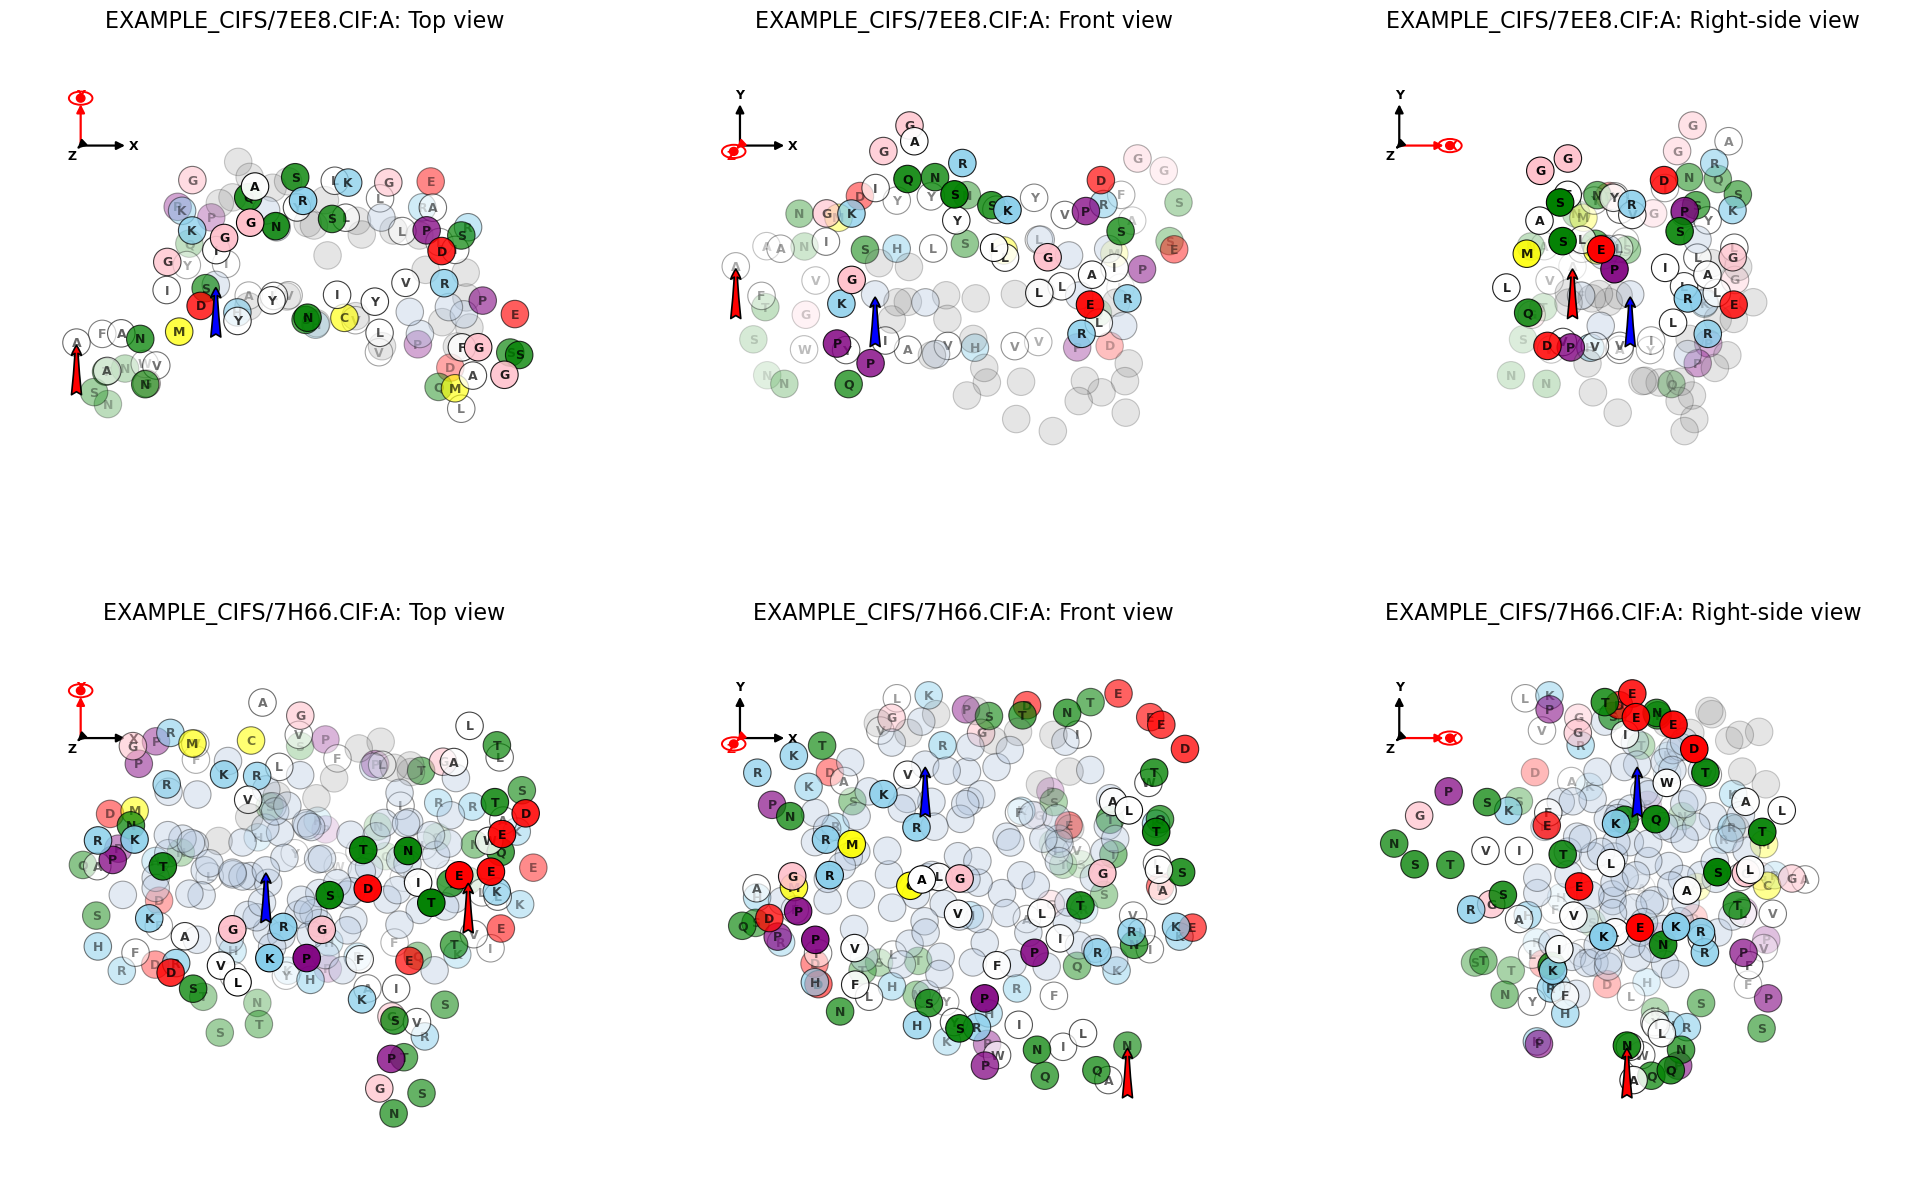

(<Figure size 2000x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'EXAMPLE_CIFS/7EE8.CIF:A: Top view'}>,
         <Axes: title={'center': 'EXAMPLE_CIFS/7EE8.CIF:A: Front view'}>,
         <Axes: title={'center': 'EXAMPLE_CIFS/7EE8.CIF:A: Right-side view'}>],
        [<Axes: title={'center': 'EXAMPLE_CIFS/7H66.CIF:A: Top view'}>,
         <Axes: title={'center': 'EXAMPLE_CIFS/7H66.CIF:A: Front view'}>,
         <Axes: title={'center': 'EXAMPLE_CIFS/7H66.CIF:A: Right-side view'}>]],
       dtype=object))

In [40]:
# entries = [
#     {"pdb": "1H9V", "chain": "A", "mask_ranges": [(232, 300), (400, 450)]},
#     {"pdb": "1E4J", "chain": "A", "mask_ranges": [(0, 30)]},
# ]

entries = [
    {"pdb": "example_cifs/7ee8.cif", "chain": "A", "mask_ranges": [(0, 30)]},
    {"pdb": "example_cifs/7h66.cif", "chain": "A", "mask_ranges": [(0, 30)]},
]


align_and_plot_three_views_depth(entries, model=1)